IMPORTING LIBRARY FILES

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression

DATASETS

In [14]:
quantity = pd.read_excel('ProductA.xlsx')
clicks = pd.read_excel('ProductA_google_clicks.xlsx')
impression = pd.read_excel('ProductA_fb_impressions.xlsx')

MERGING THE DATASETS ON DAY INDEX

In [15]:
merged = pd.read_excel('ProductA_google_clicks.xlsx').merge(pd.read_excel('ProductA_fb_impressions.xlsx'),on="Day Index").merge(pd.read_excel('ProductA.xlsx'),on="Day Index")

TO CHECK THE DATASETS ARE MERGED?

In [16]:
merged.head()

,Day Index,Clicks,Impressions,Quantity
0,2021-12-01,445,620,14
1,2021-12-02,433,890,10
2,2021-12-03,424,851,13
3,2021-12-04,427,881,22
4,2021-12-05,451,678,33


In [17]:
merged.tail()

,Day Index,Clicks,Impressions,Quantity
207,2022-06-26,114,1218,13
208,2022-06-27,106,1311,16
209,2022-06-28,109,885,13
210,2022-06-29,60,1000,16
211,2022-06-30,65,875,8


TO KNOW HOW MANY NUMBERS OF ROWS AND COLUMNS 

In [18]:
merged.shape

(212, 4)

SUMMARY OF THE MERGED DATASET 

In [19]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Clicks       212 non-null    int64         
 2   Impressions  212 non-null    int64         
 3   Quantity     212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


TO DESCRIBE THE DATA 

In [20]:
merged.describe()

,Day Index,Clicks,Impressions,Quantity
count,212,212.00000,212.000000,212.000000
mean,2022-03-16 12:00:00,358.20283,1531.702830,17.542453
min,2021-12-01 00:00:00,60.00000,620.000000,5.000000
25%,2022-01-22 18:00:00,154.00000,1209.750000,13.750000
50%,2022-03-16 12:00:00,402.50000,1460.000000,17.000000
75%,2022-05-08 06:00:00,492.75000,1862.000000,21.000000
max,2022-06-30 00:00:00,726.00000,2707.000000,38.000000
std,NaN,164.52160,440.660783,5.790423


AS WE KNOW THERE IS NO NULL VALUE SO WE WANT TO ENSURE IT

In [21]:
merged.isnull().sum()

Day Index      0
Clicks         0
Impressions    0
Quantity       0
dtype: int64

OUTLIERS ANALYSING

<Axes: >

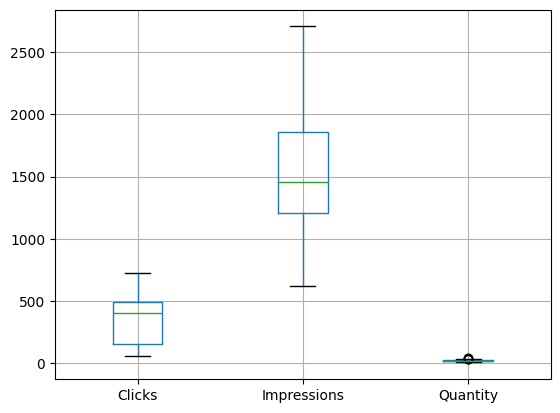

In [22]:
merged.boxplot()

CHECK FOR OUTLIERS IN EACH COLUMN USING IQR

In [23]:
def outlier_finding(merged):
    q1 , q3 = merged.quantile(0.25), merged.quantile(0.75)
    IQR = q3 - q1
    outliers = merged[(merged < (q1 - 1.5 *IQR))| (merged > (q3 + 1.5 * IQR))]
    return outliers
outlier_quantity = len(outlier_finding(merged['Quantity']))
outlier_clicks = len(outlier_finding(merged['Clicks']))
outlier_impressions = len(outlier_finding(merged['Impressions']))
#printing outliers
print("Outliers in Quantity:",outlier_quantity)
print("Outliers in Clicks:",outlier_clicks)
print("Outlier in Impressions:",outlier_impressions)

Outliers in Quantity: 5
Outliers in Clicks: 0
Outlier in Impressions: 0


SO THERE ARE 5 OUTLIERS IN THE QUANTITY ATTRIBUTE

In [24]:
print("Quantity: \n",outlier_finding(merged['Quantity']))

Quantity: 
 4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


REPLACING OUTLIER WITH 96TH PERCENTILE VALUE

In [25]:
percentile = merged["Quantity"].quantile(0.96)
print(percentile)

28.560000000000002


In [26]:
def outlier_percentile(series):
    q1, q3 = series.quantile([0.25,0.75])
    IQR = q3 - q1
    #calculating upper and lower bound
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR
    percentile_96 = series.quantile(0.96)
    return series.apply(lambda x: percentile_96 if(x < lower or x > upper)else x)
    

In [27]:
merged['imputed_quantity'] = outlier_percentile(merged['Quantity'])

In [28]:
#calculating imputed quantity
print("quantity:\t",len(outlier_finding(merged['imputed_quantity'])))

quantity:	 0


HENCE THE OUTLIER ARE REPLACED BY 96TH PERCENTILE

FEATURE ENGINEERING

In [29]:
merged.head()

,Day Index,Clicks,Impressions,Quantity,imputed_quantity
0,2021-12-01,445,620,14,14.00
1,2021-12-02,433,890,10,10.00
2,2021-12-03,424,851,13,13.00
3,2021-12-04,427,881,22,22.00
4,2021-12-05,451,678,33,28.56


IMPUTED_QUANTITY SAYS THAT OUTLIERS THAT ARE SET ON 96TH PERCENTILE

In [30]:
merged['imputed_quantity'] = outlier_percentile(merged['Quantity'])

TRANSFORMING TO LOG ATTRIBUTES

In [31]:
merged['log_quantity'] = np.log1p(merged['Quantity'])
merged['log_clicks'] = np.log1p(merged['Clicks'])
merged['log_impression'] = np.log1p(merged['Impressions'])

MONTH AND YEAR EXTRACTING

In [32]:
merged['ym'] = merged['Day Index'].dt.to_period('M')

MONTH NAME

In [33]:
merged['MonthName'] = merged['ym'].dt.strftime('%B')
month_order = ['December','January','February','March','April','May','June']
merged['MonthName'] = pd.Categorical(merged['MonthName'], categories = month_order, ordered = True)

DAYS OF WEEK

In [34]:
merged['daysofweek'] = merged['Day Index'].dt.day_name()
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
merged['daysofweek'] = pd.Categorical(merged['daysofweek'], categories = order_week, ordered = True)


WEEK OF MONTH

In [35]:
def weekOfMonth(date):
    first_day = date.replace(day=1)
    adjusted_dom = date.day + first_day.weekday()
    return int(np.ceil(adjusted_dom/7.0))

merged['weekOfMonth'] = merged['Day Index'].apply(weekOfMonth)

EXTRACTING TO NUMERIC VALUES

In [36]:
def dayToNumber(day):
    day_orders = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    return day_orders.get(day,0)

def monthToNumber(month):
    month_orders = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    return month_orders.get(month,0)

merged['daysOfWeekNum'] = merged['daysofweek'].apply(dayToNumber)
merged['MonthNum'] = merged['MonthName'].apply(monthToNumber)

WEEKDAYS AND MONTHS IN SEPARATE COLUMNS

In [37]:
merged.loc[merged['daysofweek'] == 'Monday', 'Weekday_Monday'] = 1
merged.loc[merged['daysofweek'] == 'Tuesday', 'Weekday_Tuesday'] = 1
merged.loc[merged['daysofweek'] == 'Wednesday', 'Weekday_Wednesday'] = 1
merged.loc[merged['daysofweek'] == 'Thursday', 'Weekday_Thursday'] = 1
merged.loc[merged['daysofweek'] == 'Friday', 'Weekday_Friday'] = 1
merged.loc[merged['daysofweek'] == 'Saturday', 'Weekday_Saturday'] = 1
merged.loc[merged['daysofweek'] == 'Sunday', 'Weekday_Sunday'] = 1

merged.loc[merged['MonthName'] == 'January', 'Weekday_January'] = 1
merged.loc[merged['MonthName'] == 'February', 'Weekday_February'] = 1
merged.loc[merged['MonthName'] == 'March', 'Weekday_March'] = 1
merged.loc[merged['MonthName'] == 'April', 'Weekday_April'] = 1
merged.loc[merged['MonthName'] == 'May', 'Weekday_May'] = 1
merged.loc[merged['MonthName'] == 'June', 'Weekday_June'] = 1
merged.loc[merged['MonthName'] == 'July', 'Weekday_July'] = 1
merged.loc[merged['MonthName'] == 'August', 'Weekday_August'] = 1
merged.loc[merged['MonthName'] == 'September', 'Weekday_September'] = 1
merged.loc[merged['MonthName'] == 'October', 'Weekday_October'] = 1
merged.loc[merged['MonthName'] == 'November', 'Weekday_November'] = 1
merged.loc[merged['MonthName'] == 'December', 'Weekday_December'] = 1

REPLACING

In [38]:
weekday_columns = ['Weekday_Monday','Weekday_Tuesday','Weekday_Wednesday','Weekday_Thursday','Weekday_Friday','Weekday_Saturday','Weekday_Sunday']
month_columns = ['Weekday_January','Weekday_February','Weekday_March','Weekday_April','Weekday_May', 'Weekday_June', 'Weekday_July','Weekday_August','Weekday_September','Weekday_October','Weekday_November','Weekday_December']
#fill 0 for NAN
merged[weekday_columns] = merged[weekday_columns].fillna(0)
merged[month_columns] = merged[month_columns].fillna(0)

FINAL DATA

In [39]:
merged.columns

Index(['Day Index', 'Clicks', 'Impressions', 'Quantity', 'imputed_quantity',
       'log_quantity', 'log_clicks', 'log_impression', 'ym', 'MonthName',
       'daysofweek', 'weekOfMonth', 'daysOfWeekNum', 'MonthNum',
       'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_January', 'Weekday_February',
       'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June',
       'Weekday_July', 'Weekday_August', 'Weekday_September',
       'Weekday_October', 'Weekday_November', 'Weekday_December'],
      dtype='object')

In [40]:
merged.head()

,Day Index,Clicks,Impressions,Quantity,imputed_quantity,log_quantity,log_clicks,log_impression,ym,MonthName,...,Weekday_March,Weekday_April,Weekday_May,Weekday_June,Weekday_July,Weekday_August,Weekday_September,Weekday_October,Weekday_November,Weekday_December
0,2021-12-01,445,620,14,14.00,2.708050,6.100319,6.431331,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2021-12-02,433,890,10,10.00,2.397895,6.073045,6.792344,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2021-12-03,424,851,13,13.00,2.639057,6.052089,6.747587,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2021-12-04,427,881,22,22.00,3.135494,6.059123,6.782192,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2021-12-05,451,678,33,28.56,3.526361,6.113682,6.520621,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


SO THIS THE FINAL DATASET FOR ANALYSIS

DATA ANALYSIS

CORRELATION HEATMAP

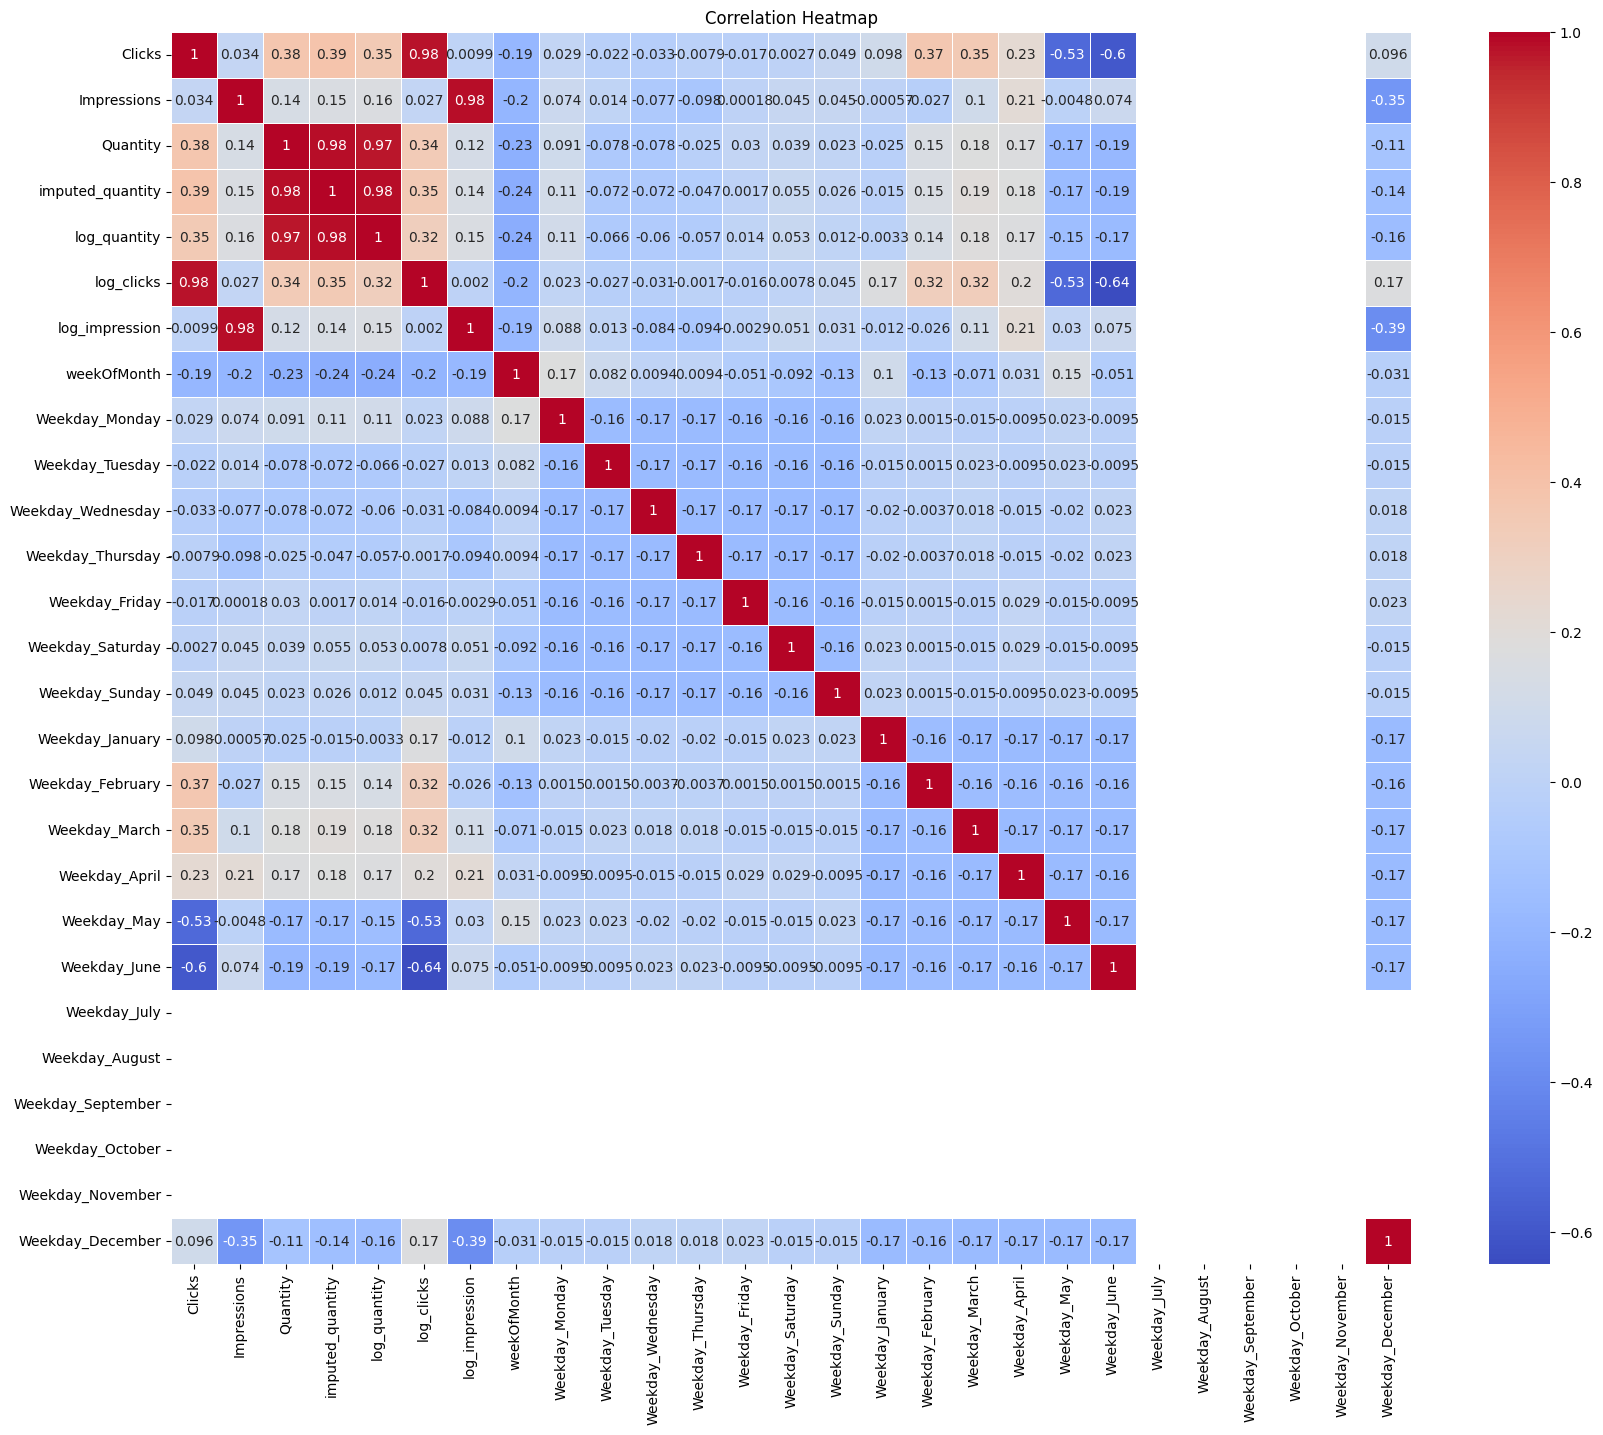

In [41]:
plt.figure(figsize=(20,16))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5).set_title("Correlation Heatmap")
plt.show()

WE KNOW THAT FROM THE ABOVE GRAPH CLICKS AFFECTS THE PRODUCT QUANTITY


In [42]:
def regression(merged, x_col, y_col, title, ax):
    x = merged[x_col].values.reshape(-1,1)
    y = merged[y_col].values
    model = LinearRegression()
    model.fit(x,y)
    y_pre = model.predict(x)
    #to get slope
    slope = model.coef_[0]
    ax.scatter(merged[x_col], merged[y_col], label='Actual')
    ax.plot(merged[x_col], y_pre,color='red',label='Regression')
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()
    return slope

PLOTTING

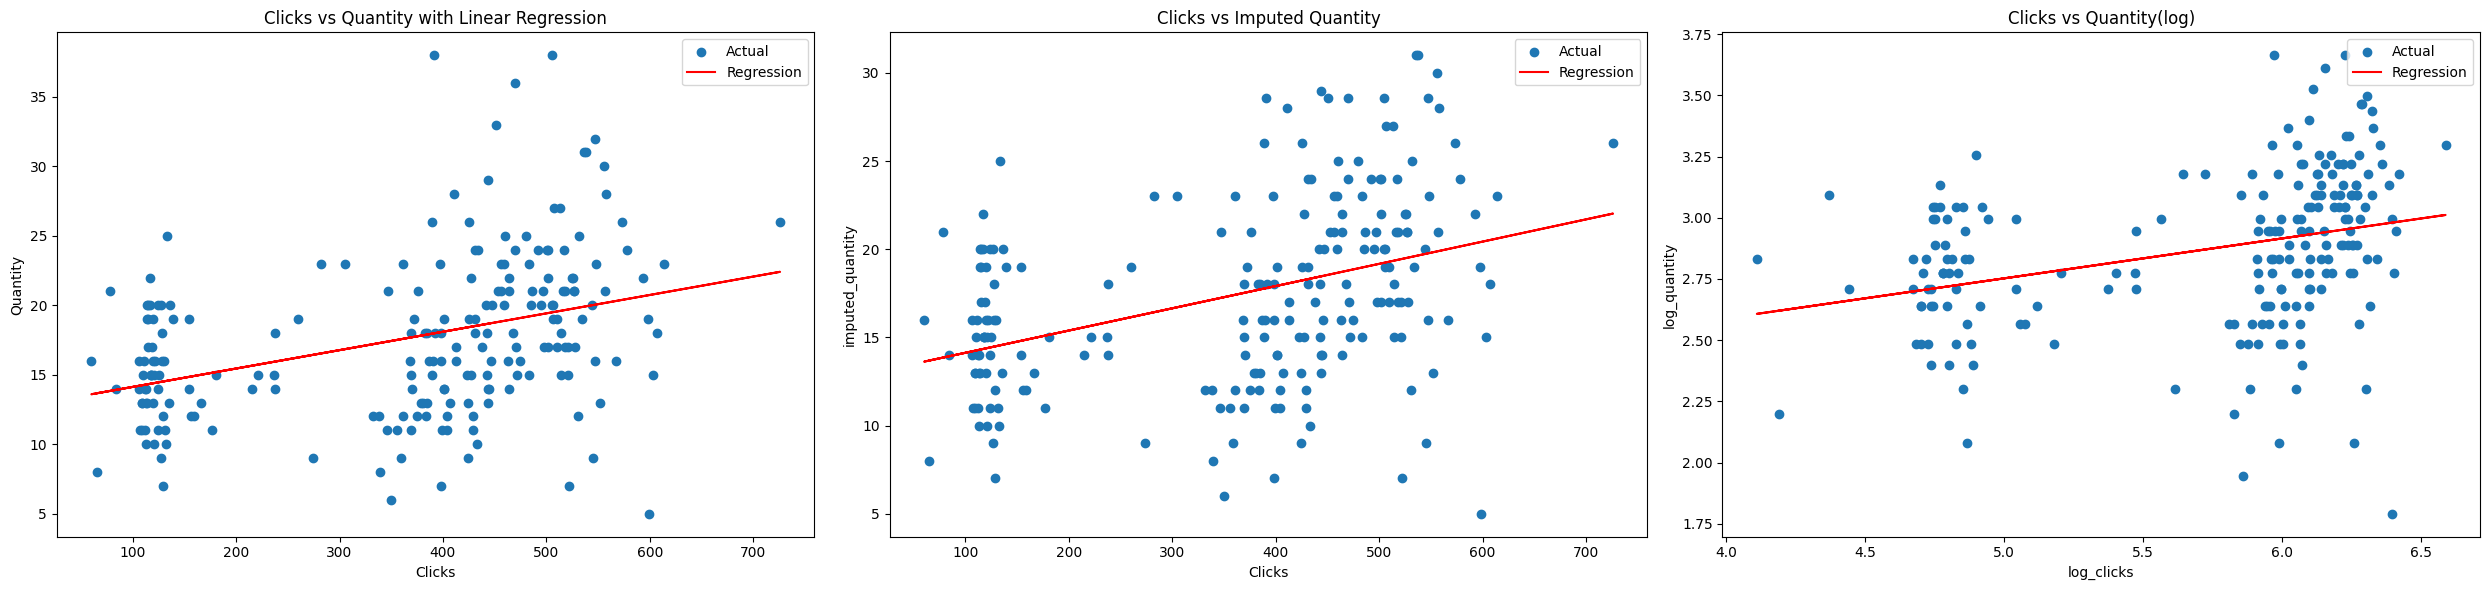

og:0.013234961483654805
imputed:0.012606614465075036
log:0.16298656613150664


In [47]:
fig, axes = plt.subplots(1,3,figsize=(25,6))
og = regression(merged,'Clicks', 'Quantity', 'Clicks vs Quantity with Linear Regression',axes[0])
imputed = regression(merged,'Clicks', 'imputed_quantity', 'Clicks vs Imputed Quantity',axes[1])
log = regression(merged,'log_clicks', 'log_quantity', 'Clicks vs Quantity(log)',axes[2])
plt.tight_layout()
plt.show()
print(f"og:{og}")
print(f"imputed:{imputed}")
print(f"log:{log}")

IMPRESSION AFFECT THE QUANTITY

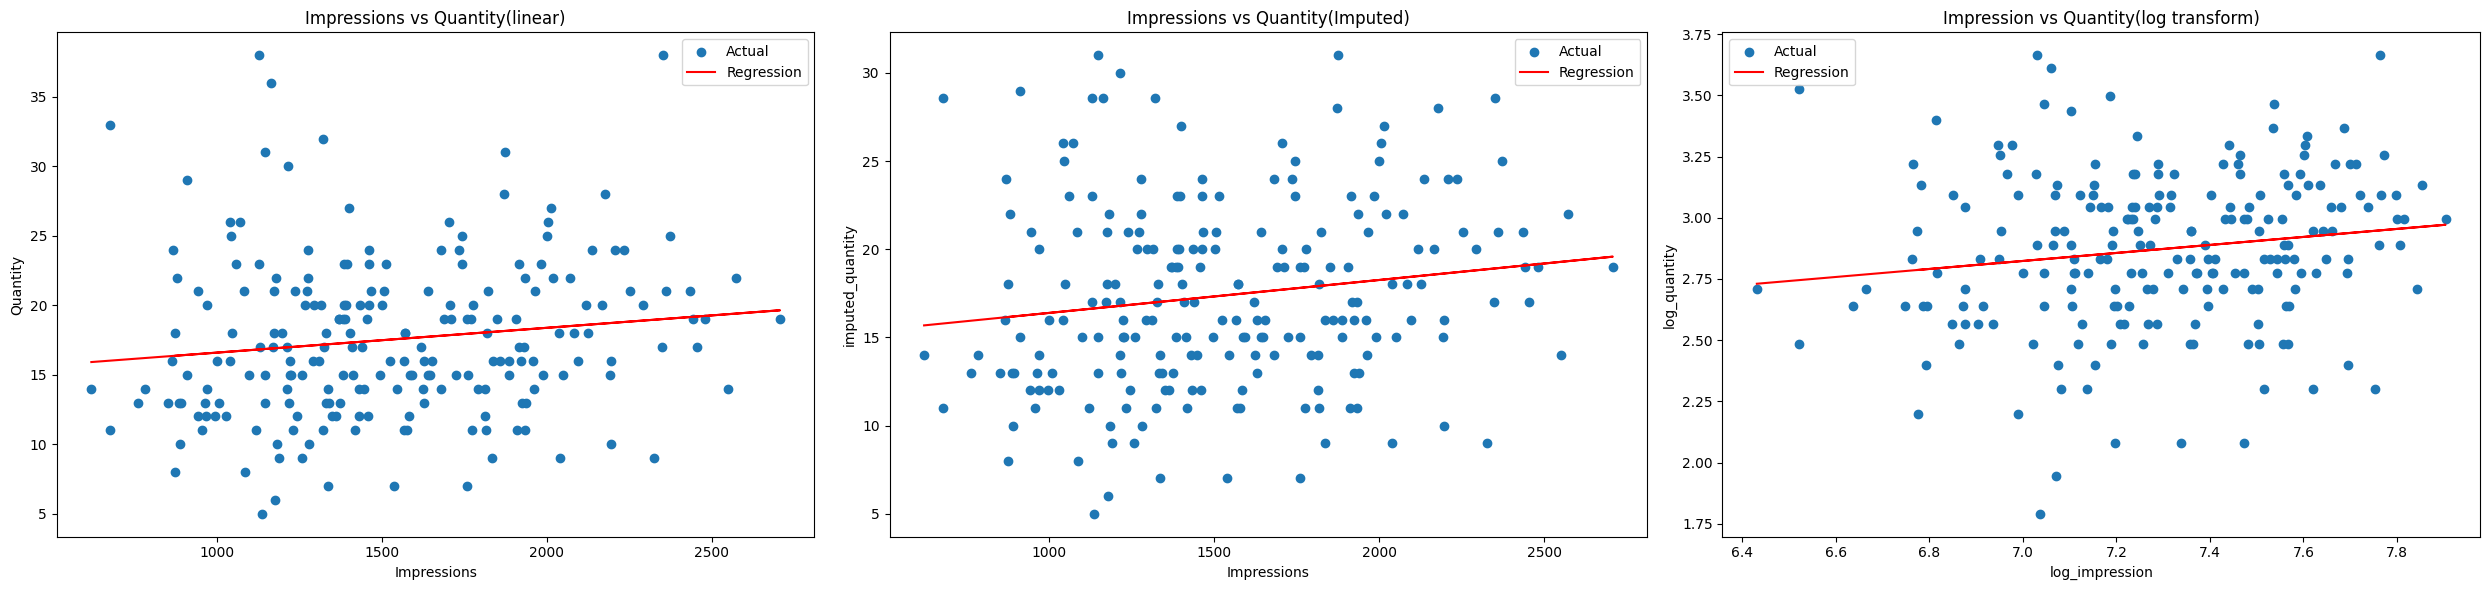

og: 0.0017863293104571235
imputed: 0.0018674999986826725
log: 0.16352913564679306


In [46]:
fig,axes = plt.subplots(1,3,figsize=(25,6))
og = regression(merged, 'Impressions','Quantity','Impressions vs Quantity(linear)',axes[0] )
imputed = regression(merged,'Impressions', 'imputed_quantity','Impressions vs Quantity(Imputed)', axes[1])
log = regression(merged, 'log_impression','log_quantity', 'Impression vs Quantity(log transform)',axes[2])
plt.tight_layout()
plt.show()
print("og:",og)
print("imputed:",imputed)
print("log:",log)


IMPRESSION LEADS TO MORE CLICKS

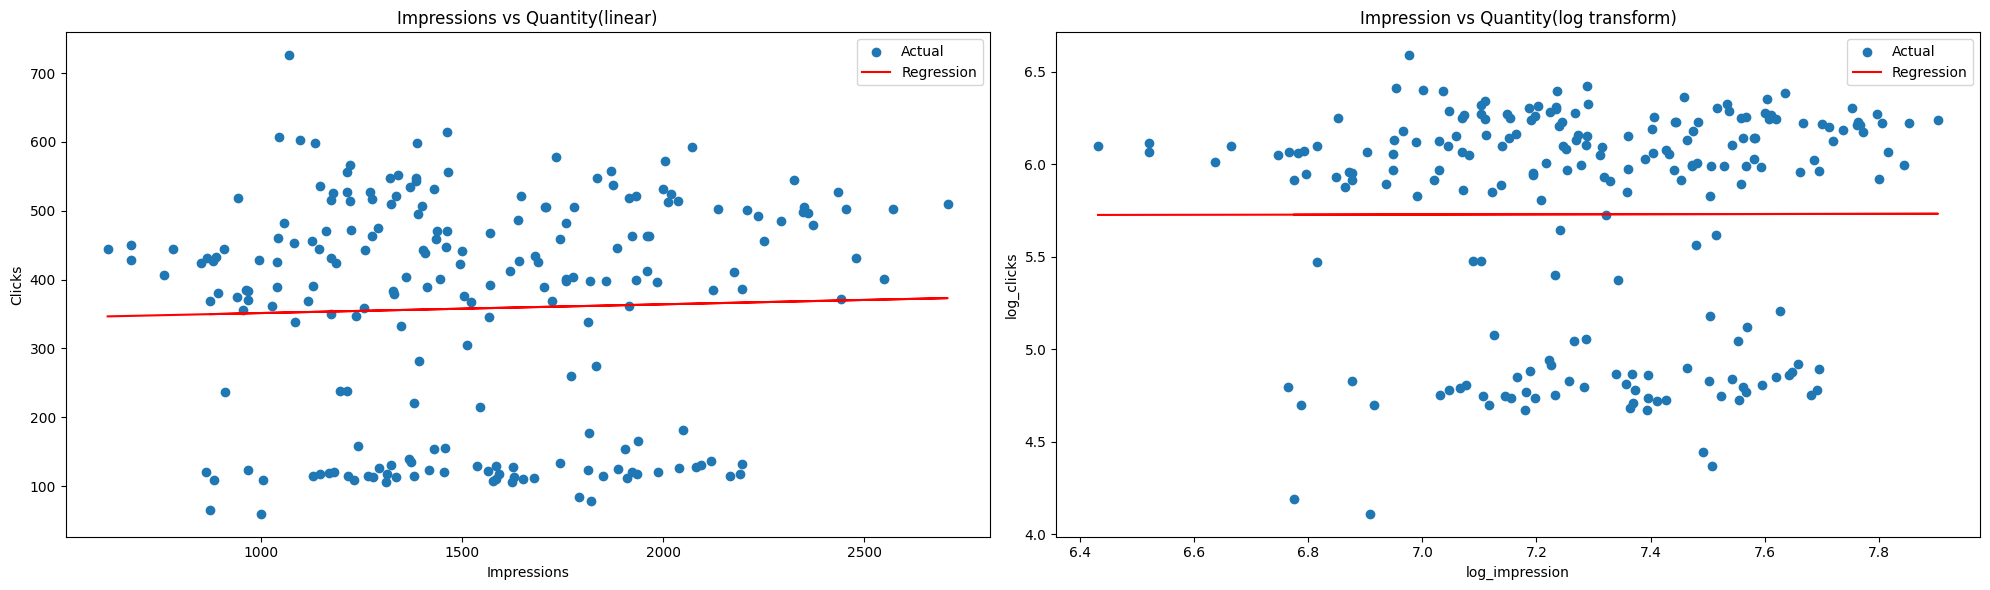

og: 0.012709310479620622
log: 0.004241626376529049


In [51]:
fig,axes = plt.subplots(1,2,figsize=(20,6))
og = regression(merged, 'Impressions','Clicks','Impressions vs Quantity(linear)',axes[0] )
log = regression(merged, 'log_impression','log_clicks', 'Impression vs Quantity(log transform)',axes[1])
plt.tight_layout()
plt.show()
print("og:",og)
print("log:",log)


DAY WISE PLOT FOR ALL 7 MONTHS

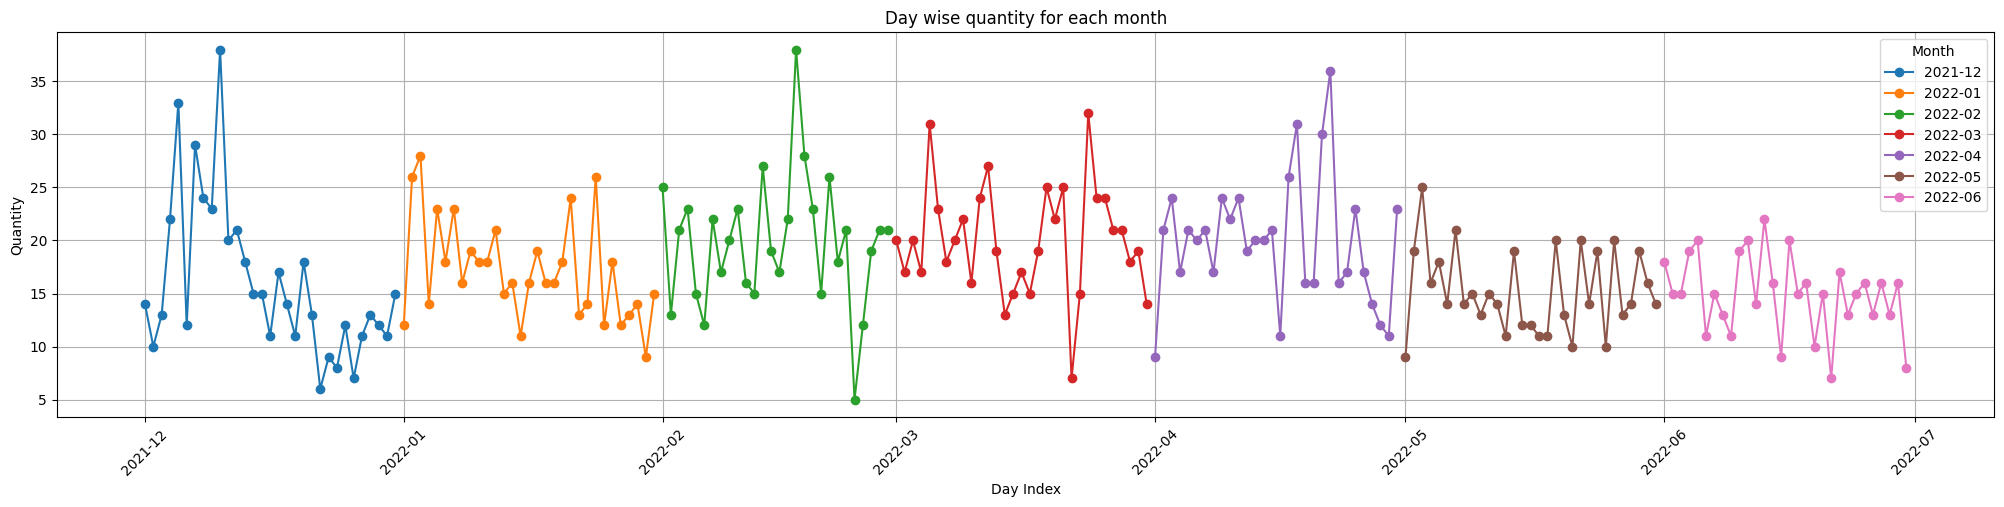

In [54]:
#quantity
plt.figure(figsize=(25,5))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Quantity'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid(True)
plt.show()   
    

    
    

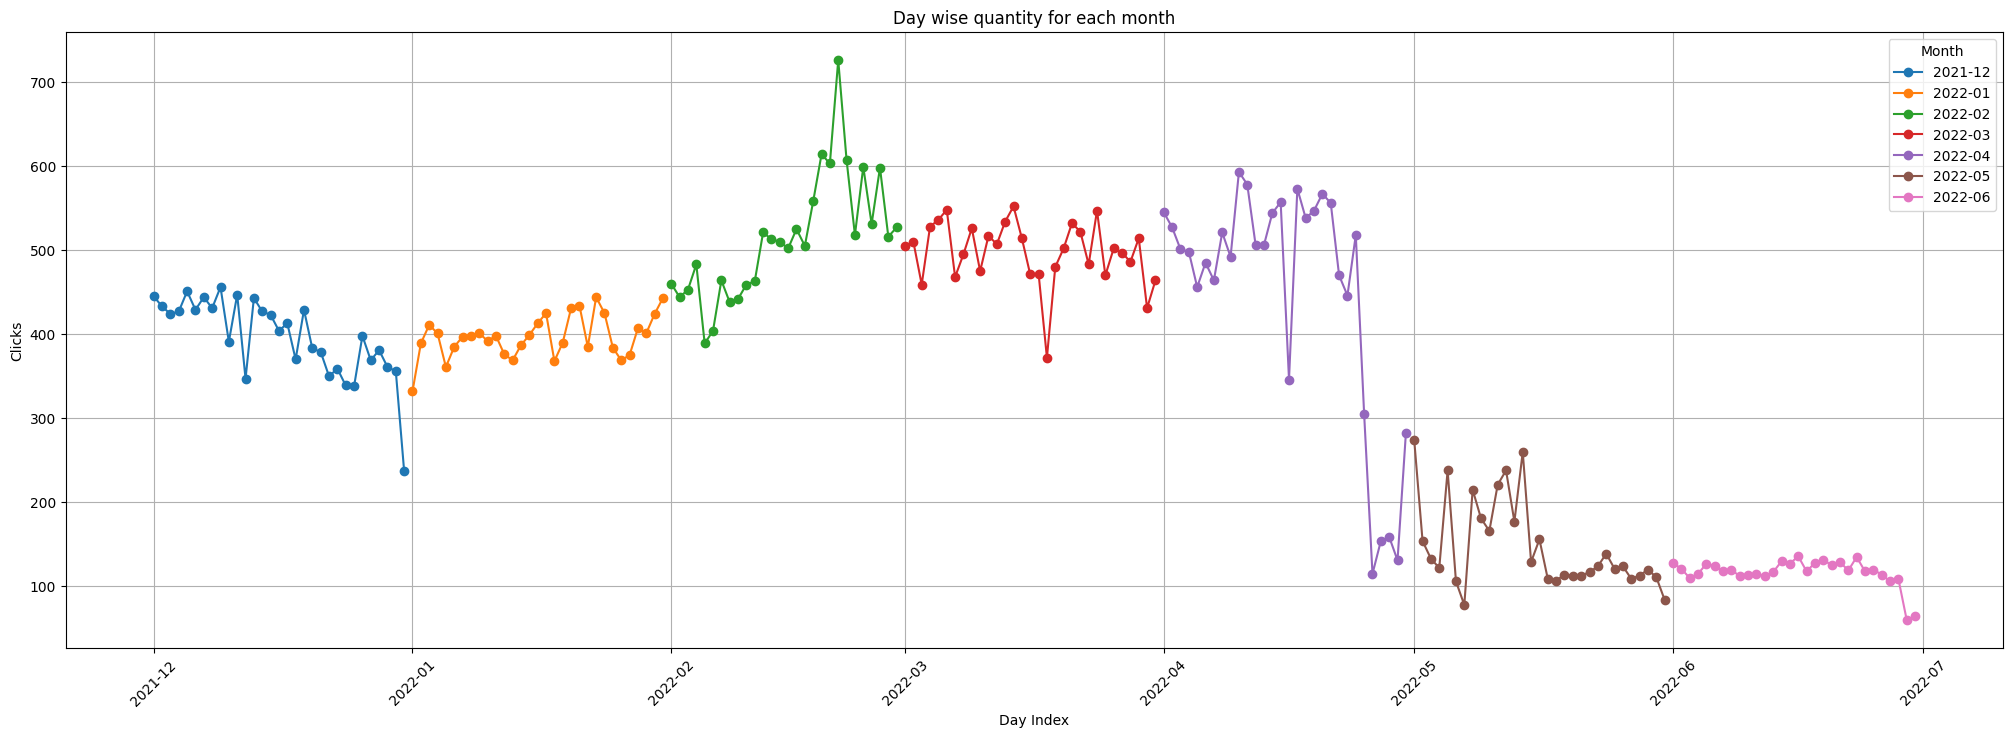

In [55]:
#clicks
plt.figure(figsize=(25,8))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Clicks'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid(True)
plt.show()   
    

    
    


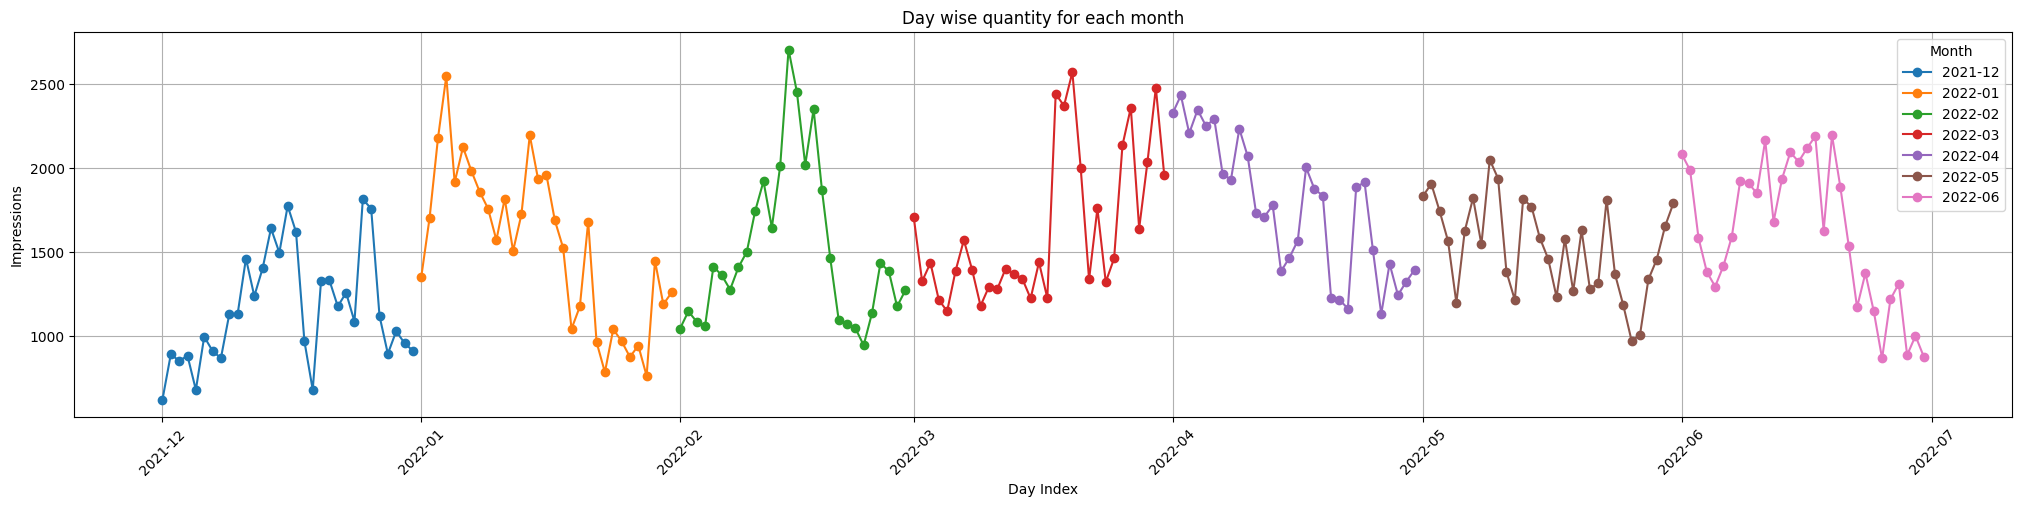

In [56]:
#impression
plt.figure(figsize=(25,5))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Impressions'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid()
plt.show()   
    

    
    

MONTHLY PLOT

In [69]:
#quantity
def annotate(ax,x,y,values):
    for i, txt in enumerate(values):
        ax.annotate(f'{txt:.0f}',(x[i],y[i]),textcoords="offset points",xytext=(0,5),ha='center')

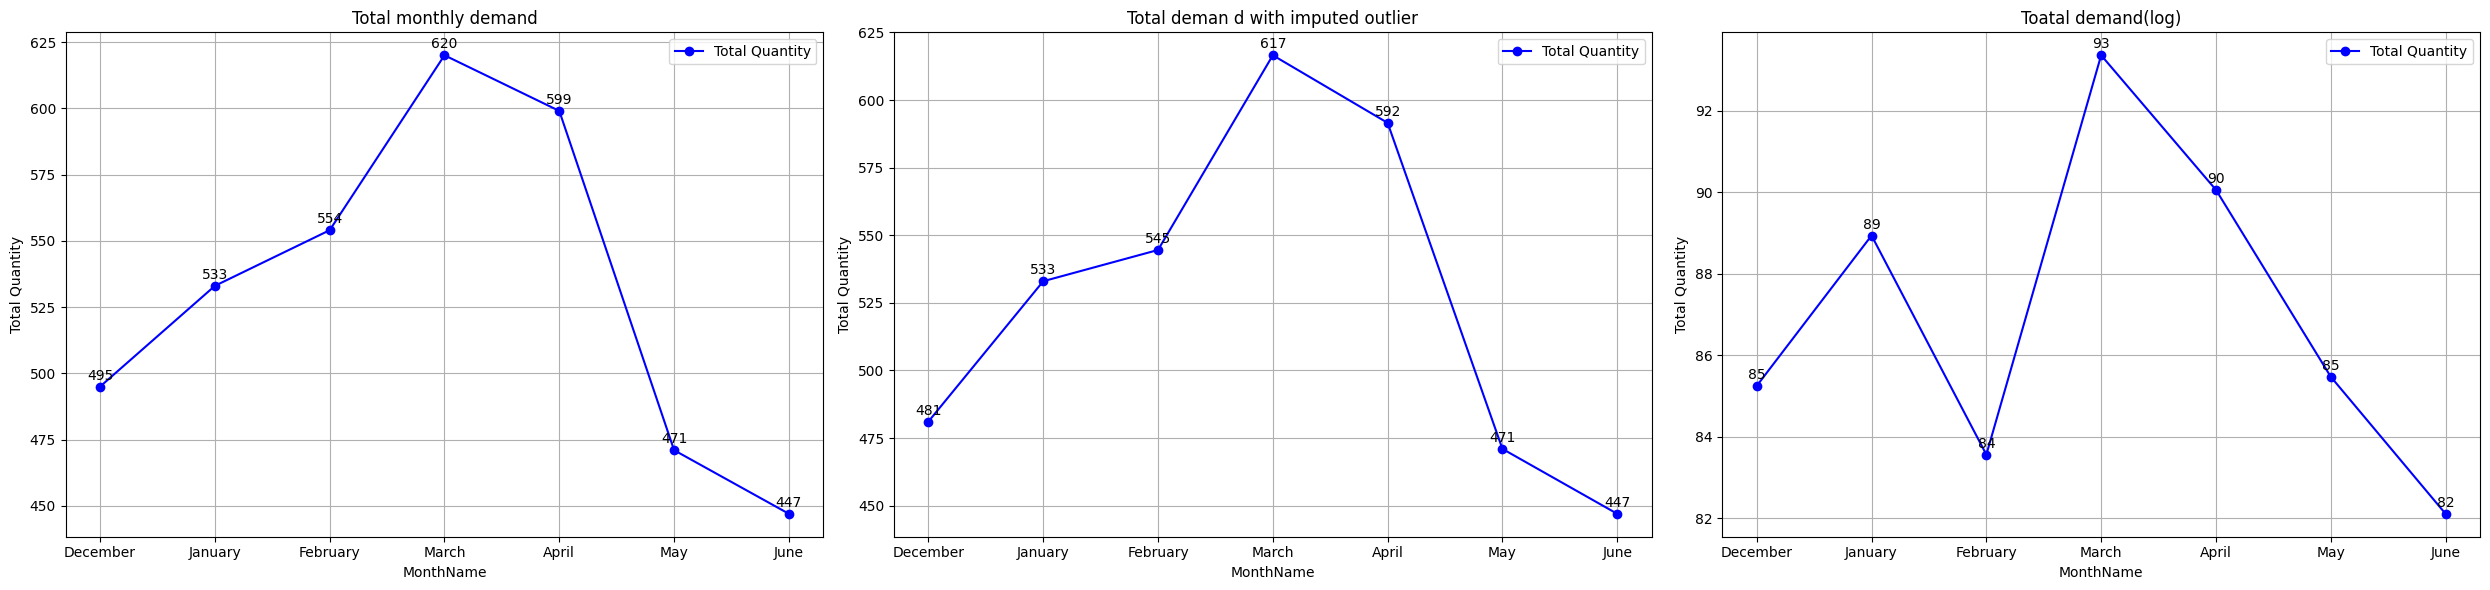

In [80]:
def plotMonthly(merged,x_col,y_col,title,ax):
    merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
    merged1 = merged1.sort_values(by=x_col)
    ax.plot(merged1[x_col],merged1[y_col],marker='o',color='blue',label="Total Quantity")
    annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
    del merged1
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel("Total Quantity")
    ax.grid(True)
    ax.legend()
    
#ploting side by side
fig,axes = plt.subplots(1,3,figsize=(25,6))
plotMonthly(merged,'MonthName','Quantity','Total monthly demand',axes[0])
plotMonthly(merged,'MonthName','imputed_quantity','Total deman d with imputed outlier',axes[1] )
plotMonthly(merged,'MonthName','log_quantity','Toatal demand(log)',axes[2])
plt.tight_layout()
plt.show()

HENCE THE DEMAND FOR THE PRODUCT INCREASES IN DECEMBER(WINTER) ARRIVES AND REACHES PEAK IN MARCH

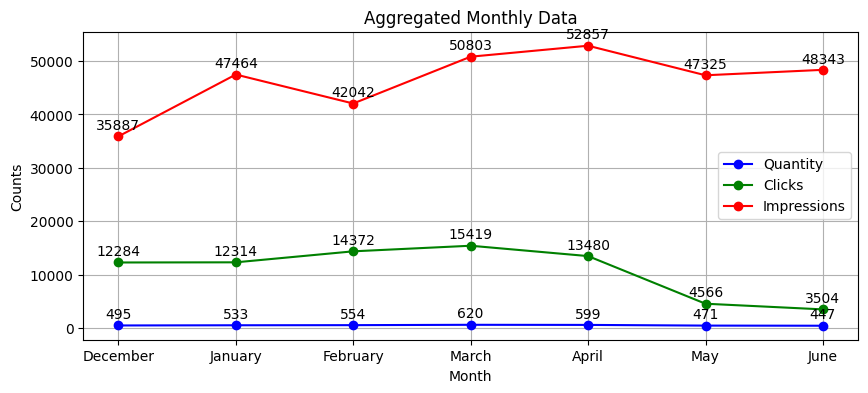

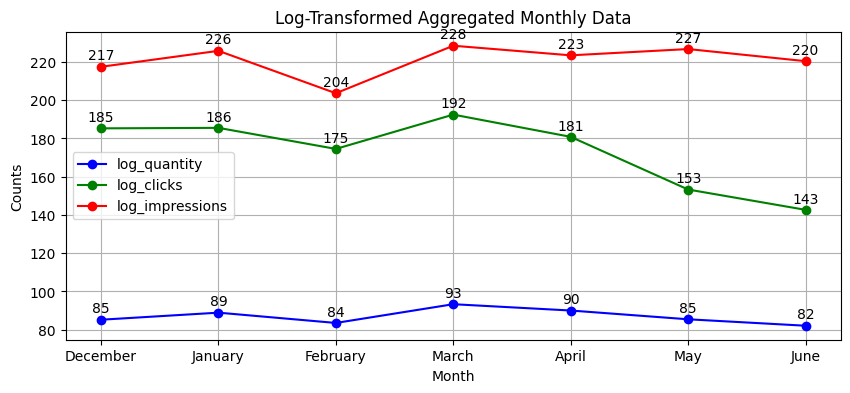

In [81]:
#for all
def plotAggregated(merged,x_col,y_cols,colors,labels,title):
    plt.figure(figsize=(10,4))
    ax=plt.gca()
    for y_col,color,label in zip(y_cols,colors,labels):
        merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
        merged1 = merged1.sort_values(by=x_col)
        ax.plot(merged1[x_col],merged1[y_col],marker='o',color=color,label=label)
        annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
        del merged1
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.show()
    
plotAggregated(merged,'MonthName',['Quantity','Clicks','Impressions'],['blue','green','red'],['Quantity','Clicks','Impressions'],'Aggregated Monthly Data')
plotAggregated(merged,'MonthName',['log_quantity','log_clicks','log_impression'],['blue','green','red'],['log_quantity','log_clicks','log_impressions'],'Log-Transformed Aggregated Monthly Data')


WE CAN SEE THAT THERE IS PEAK IN MARCH FOR  ALL

DAYS OF WEEK PLOT

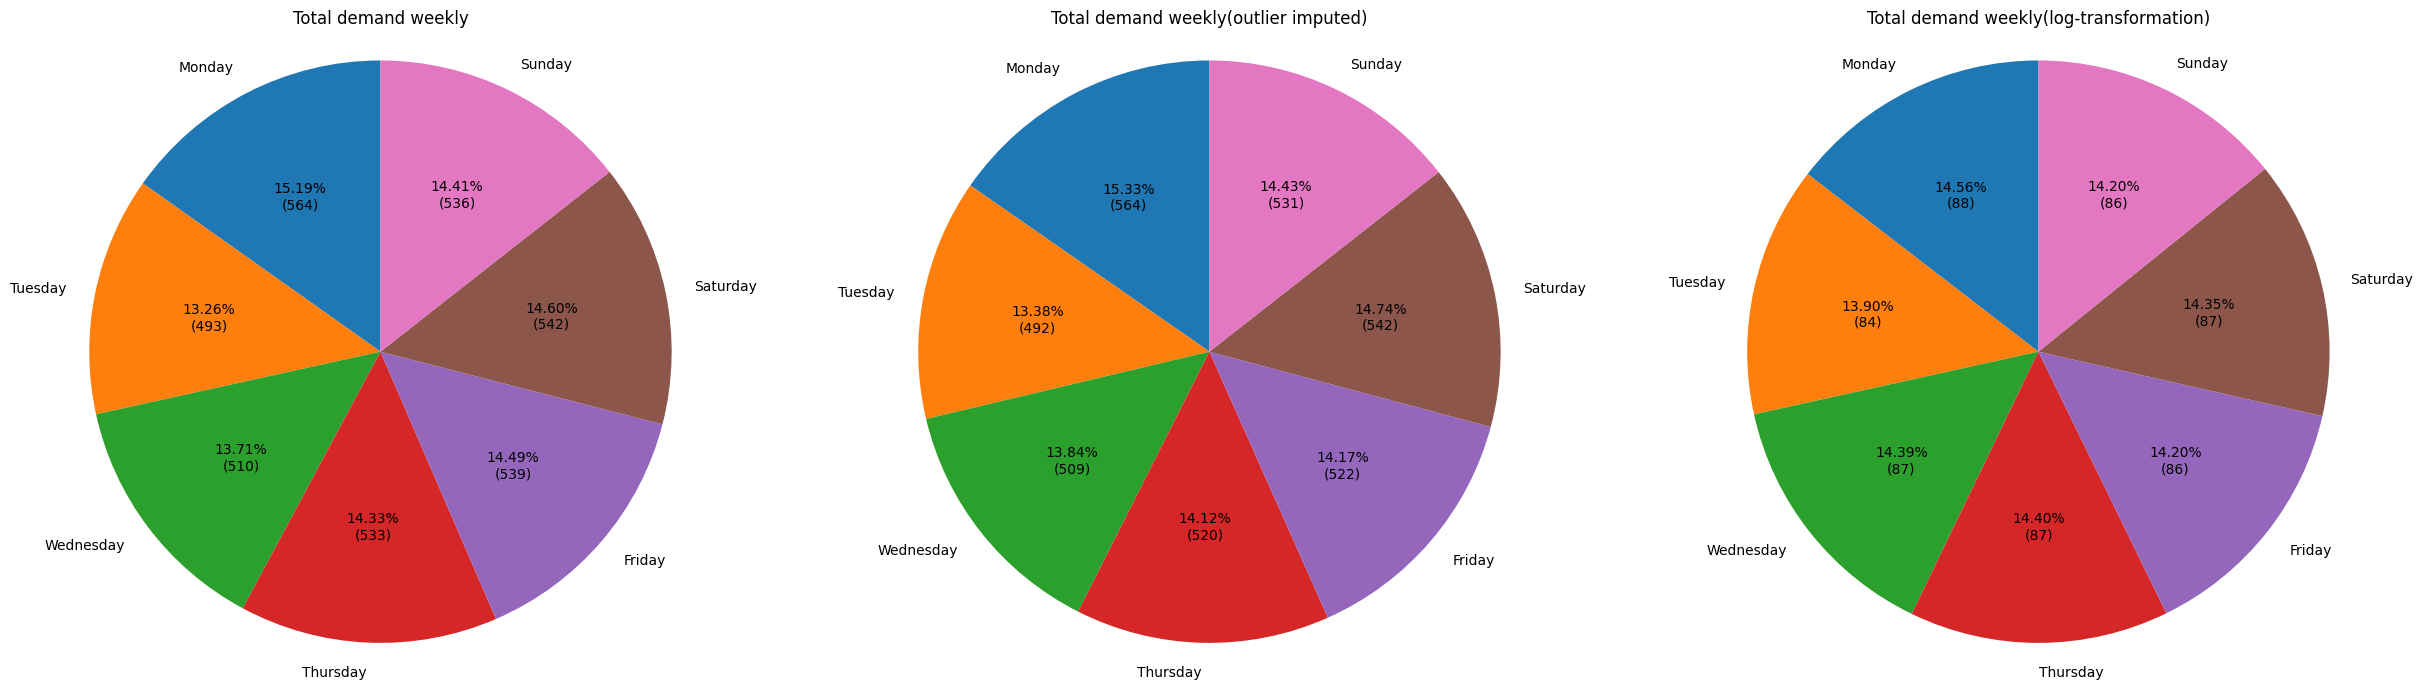

In [85]:
#quantity
def plotWeekly(merged,x_col,y_col,title,ax):
    merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
    merged1 = merged1.sort_values(by=x_col)
    labels = merged1[x_col]
    sizes = merged1[y_col]
    ax.pie(sizes,labels=labels,autopct=lambda pct: f'{pct:.2f}%\n({int(pct*sum(sizes)/100)})',startangle=90)
    ax.set_title(title)
    ax.axis('equal')
    del merged1
    
fig,axes = plt.subplots(1,3,figsize=(25,7))
plotWeekly(merged,'daysofweek','Quantity','Total demand weekly',axes[0])
plotWeekly(merged,'daysofweek','imputed_quantity','Total demand weekly(outlier imputed)',axes[1])
plotWeekly(merged,'daysofweek','log_quantity','Total demand weekly(log-transformation)',axes[2])
plt.tight_layout()
plt.show()

FROM WE CAN SAY THAT MONDAY IS PEAK OF DEMAND AND TUESDAY IS LOWEST COMPARED TO ALL

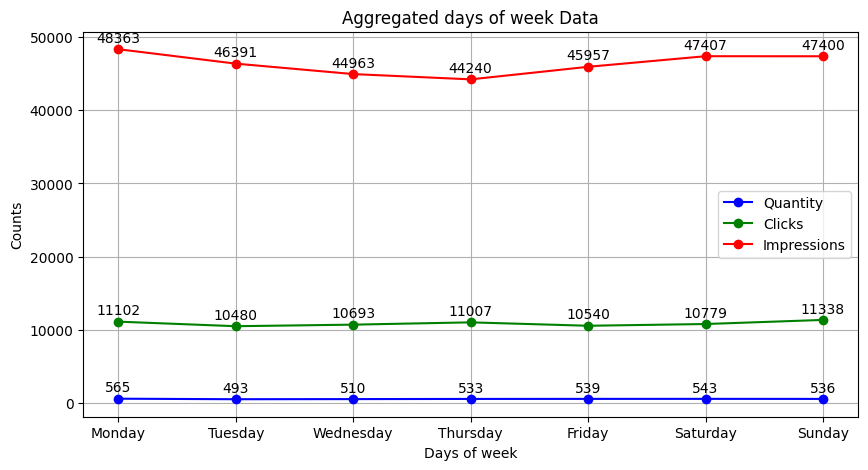

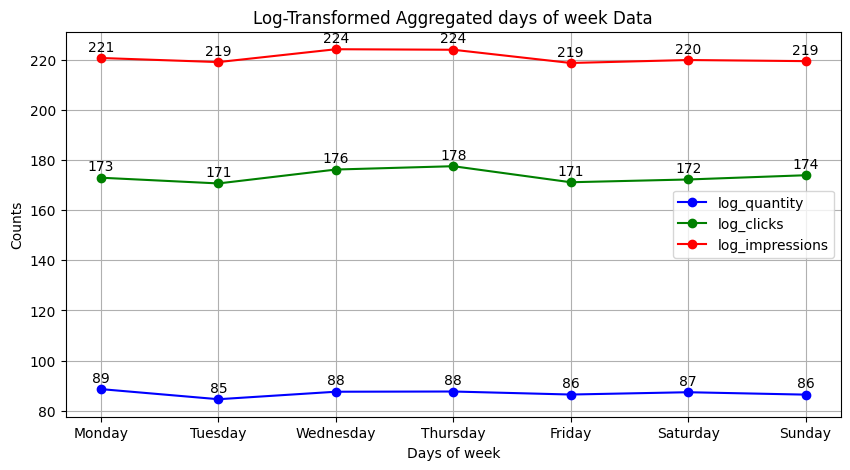

In [86]:
#for all
def plotAggregateds(merged,x_col,y_cols,colors,labels,title):
    plt.figure(figsize=(10,5))
    ax=plt.gca()
    for y_col,color,label in zip(y_cols,colors,labels):
        merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
        merged1 = merged1.sort_values(by=x_col)
        ax.plot(merged1[x_col],merged1[y_col],marker='o',color=color,label=label)
        annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
        del merged1
    ax.set_title(title)
    ax.set_xlabel('Days of week')
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.show()
    
plotAggregateds(merged,'daysofweek',['Quantity','Clicks','Impressions'],['blue','green','red'],['Quantity','Clicks','Impressions'],'Aggregated days of week Data')
plotAggregateds(merged,'daysofweek',['log_quantity','log_clicks','log_impression'],['blue','green','red'],['log_quantity','log_clicks','log_impressions'],'Log-Transformed Aggregated days of week Data')


FROM ORIGINAL DATA WE CAN SAY THAT WEEKENDS(SATURDAY,SUNDAY) AND MONDAY HAVE HIGH IMPRESSIONS AND CLICKS AND THURSDAY FOR CLICKS

IN LOG-TRANSFORMED,WEDNESDAY AND THURSDAY FOR HIGH CLICKS AND IMPRESSION